In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import sparse 

data_ratings = pd.read_excel('./data/u_data_ratings.xls')
movie_genre =pd.read_excel('./data/u_movies_genre.xls', header=None, names=['init'])
movie_items = pd.read_excel('./data/u_movies_items.xls',header=None, names=['init'])
occupation = pd.read_excel('./data/u_occupation.xls',header=None, names=['occupation'])
user_info = pd.read_excel('./data/u_user_info.xls',header=None, names=['init'])

In [2]:
from sklearn.decomposition import NMF
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [3]:
data_ratings.rename(columns={'Unnamed: 3':'Timestamp'},inplace=True)
data_ratings['Timestamp'] = pd.to_datetime(data_ratings['Timestamp'], unit='s')

movie_genre[['genre','id']] = movie_genre['init'].str.split('|', expand=True)
movie_genre = movie_genre.drop(columns=['init'])

# Formateo de los datos de movie_itms
movie_items[['Item ID','movie_name','release_date','video_release_date','imdb_url',"unknown", "Action", "Adventure", "Animation", "Children's",
             "Comedy", "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror", "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"
]] = movie_items['init'].str.split('|', expand=True)

movie_items = movie_items.drop(columns=['init'])
movie_items[['Item ID']+movie_items.columns[5:].to_list()] = movie_items[['Item ID']+movie_items.columns[5:].to_list()].apply(pd.to_numeric)

user_info[['User ID','age','gender','occupation','zip_code']] = user_info['init'].str.split('|', expand=True)
user_info = user_info.drop(columns=['init'])
user_info['User ID'] = pd.to_numeric(user_info['User ID'])
user_info['age'] = pd.to_numeric(user_info['age'])

In [8]:
movie_user = data_ratings.pivot_table(columns='Item ID', index='User ID', values='Rating', fill_value=0)

In [9]:
print(movie_user)

Item ID  1     2     3     4     5     6     7     8     9     10    ...  \
User ID                                                              ...   
1         5.0   3.0   0.0   3.0   3.0   5.0   0.0   1.0   5.0   3.0  ...   
2         4.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   2.0  ...   
3         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
4         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
5         4.0   3.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
...       ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   
914       0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
916       0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
918       0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
919       0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
921       0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   

Item ID  16

In [10]:
def recommendation_system(data,n_components=5, max_iters=200, tol=0.1, init='random',em=5):

    # Creating the instance of NMF 
    nmf = NMF(n_components=n_components, init=init, max_iter=max_iters)
    R = data;
    # training the model and obtaining W and H matrices
   

    for i in range(em):
        W = nmf.fit_transform(R)
        H = nmf.components_
        R = np.dot(W,H)
        
    pdR = pd.DataFrame(R) # more readable reconstruction matrix
    
    error = mean_squared_error(data,R) # MSE between original matrix and reconstruction
    return [pdR,W,H,error]
    

In [13]:
results = recommendation_system(movie_user,19,em=20)

In [30]:

# Supongamos que 'df' es el dataframe que contiene la columna 'User ID' y 'Rating'

# Paso 1: Contar cuántos ratings ha hecho cada usuario
user_rating_count = data_ratings.groupby('User ID')['Rating'].count().reset_index(name='rating_count')

# Paso 2: Separar a los usuarios que no han hecho ningún rating
# Usuarios que han realizado al menos 1 rating
users_with_ratings = user_rating_count[user_rating_count['rating_count'] > 0]

# Usuarios que no han hecho ningún rating (rating_count == 0)
users_without_ratings = user_rating_count[user_rating_count['rating_count'] < 20]

# Mostrar la cantidad de usuarios en cada grupo
print(f"Usuarios con ratings: {len(users_with_ratings)}")
print(f"Usuarios sin ratings: {len(users_without_ratings)}")

# Mostrar los primeros registros de cada grupo
print("Usuarios con ratings:")
print(users_with_ratings.head())

print("Usuarios sin ratings:")
print(users_without_ratings.shape)

movies_votes_counts = data_ratings.groupby('Item ID')['Rating'].count().reset_index(name='rating_count')
less_than_20 = movies_votes_counts[movies_votes_counts['rating_count'] < 1]
print(less_than_20.shape)

Usuarios con ratings: 916
Usuarios sin ratings: 220
Usuarios con ratings:
   User ID  rating_count
0        1           235
1        2            53
2        3            49
3        4            19
4        5           151
Usuarios sin ratings:
(220, 2)
(0, 2)


In [47]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder

In [34]:
gender_cluster_matrix = pd.merge(data_ratings, user_info[['User ID','gender']], how='left',on='User ID' ).drop(columns=['Timestamp'])
print(gender_cluster_matrix.head())

   User ID  Item ID  Rating gender
0      196      242       3      M
1      186      302       3      F
2       22      377       1      M
3      244       51       2      M
4      166      346       1      M


In [71]:
gc_encoded = pd.get_dummies(gender_cluster_matrix, columns=['gender'], drop_first=False)
print(gc_encoded)

       User ID  Item ID  Rating  gender_F  gender_M
0          196      242       3     False      True
1          186      302       3      True     False
2           22      377       1     False      True
3          244       51       2     False      True
4          166      346       1     False      True
...        ...      ...     ...       ...       ...
65530      739      187       4     False      True
65531      787      331       3      True     False
65532      683      311       3     False      True
65533      807       62       3      True     False
65534      705      684       3      True     False

[65535 rows x 5 columns]


In [39]:
def elbow_method(X, max_clusters=10):
    inertia = []
    K = range(1, max_clusters+1)

    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
        kmeans.fit(X)
        inertia.append(kmeans.inertia_)

    plt.figure(figsize=(8, 5))
    plt.plot(K, inertia, 'bx-')
    plt.xlabel('Número de clusters (K)')
    plt.ylabel('Inercia')
    plt.title('Método del Codo para encontrar el número óptimo de clusters')
    plt.grid(axis='x')
    plt.show()

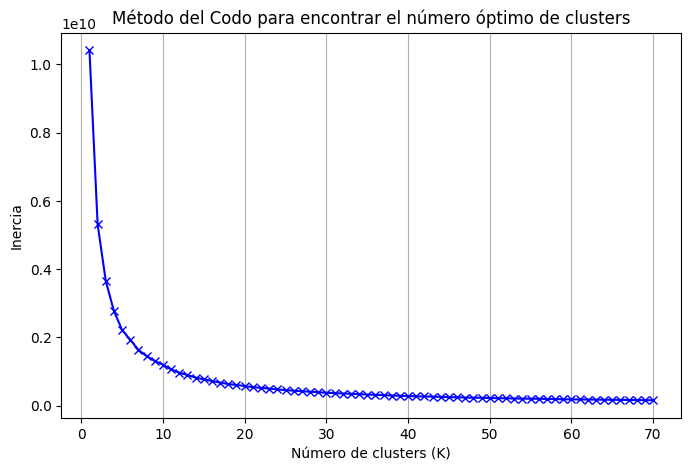

In [41]:
elbow_method(gc_encoded, 70)

D:\Progra\Python\ML Projects\ml\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


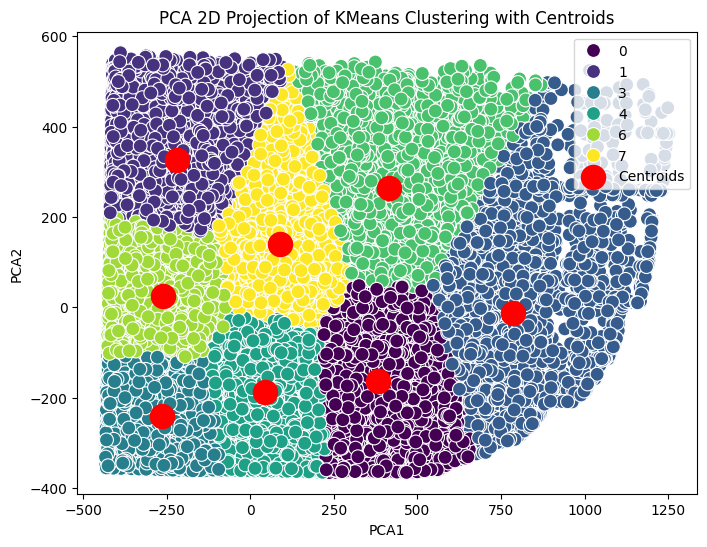

In [72]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Select the features you want to use for KMeans and PCA
features = gc_encoded[['User ID', 'Item ID', 'Rating', 'gender_F', 'gender_M']]  # Use same features for both KMeans and PCA

# Apply KMeans on the selected features
kmeans = KMeans(n_clusters=8, random_state=42)
kmeans.fit(features)

# Assign cluster labels to the dataframe
gc_encoded["Cluster"] = kmeans.labels_

# Perform PCA to reduce to 2 components
pca = PCA(n_components=2)
pca_result = pca.fit_transform(features)

# Add the PCA results back to the dataframe
gc_encoded['PCA1'] = pca_result[:, 0]
gc_encoded['PCA2'] = pca_result[:, 1]

# Project the KMeans centroids into the PCA space
centroids_pca = pca.transform(kmeans.cluster_centers_)

# Plot the PCA results with the clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=gc_encoded, palette='viridis', s=100)

# Plot the centroids in the PCA space
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], s=300, c='red', label='Centroids')
plt.title('PCA 2D Projection of KMeans Clustering with Centroids')
plt.legend()
plt.show()


In [73]:
# Group by clusters and calculate the average rating per movie within each cluster
#gender_analysis = pd.merge(gc_encoded, movie_items[['Item ID','movie_name']], how='left', on="Item ID")
cluster_movies = gc_encoded.groupby(['Cluster', 'Item ID']).agg({'Rating': 'mean'}).reset_index()

# Sort to find top-rated movies for each cluster
top_movies_per_cluster = cluster_movies.groupby('Cluster').apply(lambda x: x.nlargest(5, 'Rating'))

# Merge with movie titles to make the results more interpretable
top_movies_per_cluster = top_movies_per_cluster.merge(movie_items[['Item ID', 'movie_name']], on='Item ID', how='left')

# View top movies per cluster
print(top_movies_per_cluster)


    Cluster  Item ID    Rating  \
0         0      814  5.000000   
1         0      909  5.000000   
2         0     1031  5.000000   
3         0     1062  5.000000   
4         0     1097  5.000000   
5         1      372  5.000000   
6         1      408  5.000000   
7         1      482  5.000000   
8         1      490  5.000000   
9         1      504  5.000000   
10        2      966  5.000000   
11        2      974  5.000000   
12        2     1144  5.000000   
13        2     1189  5.000000   
14        2     1191  5.000000   
15        3      113  5.000000   
16        3      119  5.000000   
17        3      347  5.000000   
18        3       64  4.540541   
19        3      114  4.500000   
20        4      306  5.000000   
21        4      341  5.000000   
22        4      661  5.000000   
23        4      641  4.833333   
24        4      645  4.666667   
25        5      607  5.000000   
26        5      612  5.000000   
27        5      634  5.000000   
28        5   

C:\Users\Victo\AppData\Local\Temp\ipykernel_16440\1721123278.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_movies_per_cluster = cluster_movies.groupby('Cluster').apply(lambda x: x.nlargest(5, 'Rating'))


In [74]:
# View the KMeans cluster centroids
centroid_df = pd.DataFrame(kmeans.cluster_centers_, columns=features.columns)
print(centroid_df)

      User ID      Item ID    Rating  gender_F  gender_M
0  212.989078   812.538440  3.245532  0.256596  0.743404
1  688.714026   199.168468  3.618701  0.273689  0.726311
2  373.950908  1212.575300  2.987983  0.286627  0.713373
3  119.319176   168.674318  3.700524  0.221037  0.778963
4  180.472192   474.387147  3.584024  0.220420  0.779580
5  640.846421   834.988650  3.239750  0.302525  0.697475
6  384.905662   165.740845  3.704848  0.252603  0.747397
7  510.183259   511.950092  3.527462  0.281225  0.718775


In [90]:
# Merge gc_encoded with movie_genre to include genres
df_with_genres = gc_encoded.merge(movie_genre, on='Item ID', how='left')

# Calculate average ratings per genre in each cluster
genre_avg_ratings = df_with_genres.groupby('Cluster').agg({genre: 'mean' for genre in movie_genre.columns[5:]})
print(genre_avg_ratings)

# Create heatmap of genre preferences per cluster
plt.figure(figsize=(15, 8))
sns.heatmap(genre_avg_ratings, cmap='coolwarm', annot=True)
plt.title('Genre Preferences by Cluster')
plt.show()

KeyError: 'Item ID'

In [89]:
genre_avg_ratings

,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
Cluster,,,,,,,,,,,,,,,,,,,
0,0.000000,0.177346,0.092713,0.017862,0.054437,0.350865,0.034590,0.017720,0.400624,0.018004,0.031046,0.056705,0.017012,0.040828,0.232350,0.052169,0.246527,0.037993,0.010207
1,0.000114,0.316856,0.164009,0.032574,0.065262,0.287130,0.106492,0.003872,0.401595,0.005923,0.010478,0.055467,0.048064,0.053645,0.200797,0.180979,0.231321,0.115831,0.017198
2,0.000255,0.118441,0.065206,0.022415,0.059093,0.341060,0.062404,0.032094,0.438869,0.010443,0.004075,0.011971,0.046103,0.030311,0.140856,0.035914,0.126337,0.021905,0.010698
3,0.000271,0.312737,0.155328,0.031934,0.064954,0.293830,0.106930,0.005790,0.402298,0.004071,0.013208,0.048399,0.046680,0.043514,0.207527,0.191153,0.235028,0.120590,0.016917
4,0.000000,0.209305,0.132844,0.060231,0.103150,0.279635,0.058428,0.002525,0.379779,0.030176,0.018634,0.065521,0.078865,0.079106,0.164823,0.073696,0.168189,0.088723,0.029935
5,0.000000,0.174960,0.095811,0.025226,0.065494,0.347605,0.034946,0.013191,0.400370,0.019903,0.021523,0.039343,0.023143,0.042351,0.240685,0.048831,0.238371,0.040037,0.009026
6,0.000207,0.308318,0.151885,0.033630,0.061815,0.292054,0.113845,0.006133,0.404659,0.005237,0.011026,0.053683,0.048791,0.044518,0.196265,0.183240,0.247812,0.118806,0.018951
7,0.000000,0.209087,0.138687,0.051644,0.096421,0.253731,0.051248,0.003566,0.393607,0.026285,0.031039,0.075155,0.069740,0.071457,0.158764,0.072646,0.189011,0.094836,0.027870
